# 6b. File IO

**Ex. 1)** Create a function that takes as input a city name (eg: **w.sask** and **w.vic** for Saskatoon and Victoria respectively), and a weather feature key (eg: **Mean Temp (°C)** or **Total Rain (mm)**).  The function will create a matplotlib plot (a point plot) where the x-axis represents the date of the measurement, and the y-axis represents the measurement corresponding to the key. Include the linear and quadratic least-squares approximations.

Use the code from Lecture 6b, i.e. use data from the **mdat** variable.

How do your trend lines compare with the global warming predictions we see in newspaper articles?

In [90]:
import pprint as pp
import datetime as dt ## library to manipulate dates and times
import matplotlib.pyplot as plt
import os
import fnmatch as fn
import scipy.optimize 
%matplotlib inline

def parse_fname(fname):
    with open(fname, encoding='utf8') as f:
        content = f.read().split('\n')
        '''this splits the string.  [typical way of doing multi-line comments.]
        ## converts the file into one big text string.
        ## and split by lines
        ## two things you can do. rather than use read() command you can use readlines()'''
        ## problem in the new files the header is only 5 lines long
        leglines = [i for i in range(len(content)) if 'legend' in content[i].lower()]
        if len(leglines)!=1:
            print("Error not unique legend line.")
            return(None)
        
        ID_pairs = [x.replace('"', '').replace('\ufeff', '').split(',')\
                    for x in content[:leglines[0]-1]]
        fdat = dict(ID_pairs)
        to_float=['Elevation', 'Latitude', 'Longitude']
        to_int = ['WMO Identifier']
        for k in to_float:
            if k in fdat.keys():
                fdat[k] = float(fdat[k])
        for k in to_int:
            if k in fdat.keys():
                if fdat[k]=='':
                    del fdat[k] ## removal of key from dictionary 
                else:
                    fdat[k] = int(fdat[k])
        ## next: let's load the keys for the row data.     
        keylines = [i for i in range(len(content)) if 'date/time' in\
                   content[i].lower()]
        if len(keylines)!=1:
            print('Error! Need only one key line.')
            return(None)
        ## parse the row the row data, i.e. all data from "keylines" down.
        keys = content[keylines[0]].replace('"','').split(',')
        ## now the remaining rows, we want to put into a list of dictionaries
        fdat['rows']=[]
        for L in content[keylines[0]+1:]:
            L=L.replace('"','').split(',')
            if len(L)!=len(keys):
                continue
            ignore_keys = ['Year', 'Month', 'Day']
            X = {keys[i]:L[i] for i in range(len(keys)) if L[i]!=''\
                 and (keys[i] not in ignore_keys)}
            ## make the data more useful 
            to_date = ['Date/Time']
            to_float = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',\
                       'Total Precip (mm)', 'Total Rain (mm)', 'Total Snow (cm)',\
                       'Snow on Grnd (cm)', 'Cool Deg Days (°C)', 'Heat Deg Days (°C)']
            
            for k in to_date:
                X[k] = dt.datetime.strptime(X[k], "%Y-%m-%d").date()
            for k in to_float:
                if k in X.keys():
                    X[k] = float(X[k])
            
            fdat['rows'].append(X)
        return(fdat)    


In [97]:
def parse_name_lab(city_name, weather_key):
    '''
    Input: 
        - city_name: a city name (eg: w.sask and w.vic for Saskatoon and Victoria respectively)
        - weather_key: a weather feature key (only Mean Temp (°C) and Total Rain (mm) as of now)
    Output:
        The function will create a matplotlib plot (a point plot) where:
        - x-axis represents the date of the measurement, 
        - y-axis represents the measurement corresponding to the key
        Include the linear and quadratic least-squares approximations
    '''
    route = '../../mp248-course/Data/CWD/'
    if "Calgary" in city_name:
        wsubdirs = fn.filter(os.listdir(route), "w.cal")
    elif "Edmonton" in city_name:
        wsubdirs = fn.filter(os.listdir(route), "w.edm")
    elif "Saskatoon" in city_name:
        wsubdirs = fn.filter(os.listdir(route), "w.sask")
    elif "Victoria" in city_name:
        wsubdirs = fn.filter(os.listdir(route), "w.vic")
    else:
        return(print(city_name, 'not found'))
    
    mdat=dict()
    for wd in wsubdirs:
        files = fn.filter(os.listdir(route+wd), "eng-daily*.csv")
        for wdf in files:
            fname = route+wd+'/'+wdf
            pf = parse_fname(fname)
            for v in pf['rows']:
                K = (wd, v['Date/Time'])
                mdat[K] = v
    
    k1 = 'Date/Time'
    if 'Mean Temp' in weather_key:
        k2 = 'Mean Temp (°C)'
    elif 'Total Rain' in weather_key:
        k2 = 'Total Rain (mm)'
    else:
        return(print(weather_key,'not found'))
    
    if "Victoria" in city_name:
        MM=[(v[k1], v[k2]) for k,v in mdat.items() if k[0]=='w.vic'\
        and (k1 in v.keys()) and (k2 in v.keys())]
    elif "Calgary" in city_name:
        MM=[(v[k1], v[k2]) for k,v in mdat.items() if k[0]=='w.cal'\
        and (k1 in v.keys()) and (k2 in v.keys())]
    elif "Saskatoon" in city_name:
        MM=[(v[k1], v[k2]) for k,v in mdat.items() if k[0]=='w.sask'\
        and (k1 in v.keys()) and (k2 in v.keys())]
    elif "Edmonton" in city_name:
        MM=[(v[k1], v[k2]) for k,v in mdat.items() if k[0]=='w.edm'\
        and (k1 in v.keys()) and (k2 in v.keys())]
    else:
        return(print(city_name, 'not found (Error 2)'))
    

    # Plot
    plt.plot([x[0] for x in MM], [x[1] for x in MM], 'ro')
    plt.xlabel(k1)
    plt.ylabel(k2)
    # Linear and quadratic least square approximations
    #scipy.optimize.curve_fit(func ,[x[0] for x in MM], [x[1] for x in MM])

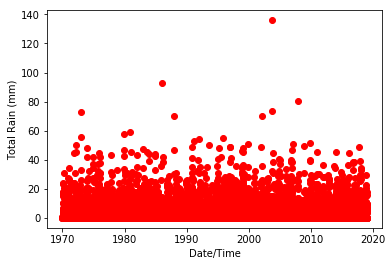

In [98]:
parse_name_lab('Victoria', 'Total Rain (mm)')

----

**Ex. 2)** Write a function that will take as input three arguments.  The first two arguments are city names in our 6b convention (eg: **w.sask** and **w.vic** for Saskatoon and Victoria respectively), and the third argument would be a key for a floating-point data type (eg: **Mean Temp (°C)** or **Total Rain (mm)**).  Your function would then create a matplotlib plot for that weather feature, of one city's weather vs. the other for all the dates we have in common in our data set.  Include a linear and quadratic least-squares approximation. 

Make a plot for mean temperature, for every pair of cities.



In [ ]:
def parse_name_lab2(city_name1, city_name2, weather_key):